# Causal Evaluation 
> Using causal analysis to compute the influence of T on Y

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<ipython-input-1-ac09909db896>:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [1]:
#! pip install dowhy
from dowhy import CausalModel
import dowhy.datasets

In [2]:
from pathlib import Path
import csv
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools

pd.options.display.float_format = '{:.2f}'.format

In [3]:
import seaborn as sns
sns.set_theme(style="darkgrid")


In [4]:
from pandas.plotting import bootstrap_plot

In [5]:
%matplotlib inline

## Load Data Samples

In [6]:
#Load data samples
eval_df = pd.read_csv(
    '/workspaces/CodeCheckList/data/linguistic_capabilities/huggingface-CodeBERTa-small-v1_100.0_20.csv',
    index_col=0
    )

In [7]:
eval_df.head(2)

,sample_id,ast_element,sample,masking_rate,numper_of_masked_tokens,ast_element_ocurrences,mask_jaccard,mask_sorensen_dice,mask_levenshtein,mask_random_avg_jaccard,...,mask_random_std_jaccard,mask_random_std_sorensen_dice,mask_random_std_levenshtein,n_ast_errors,ast_levels,n_whitespaces_,complexity,nloc,token_counts,n_ast_nodes
0,0,comparison_operator,def test_should_generate_secret_with_specified...,1.00,20,1,0.85,0.92,0.90,0.98,...,0.03,0.01,0.02,0,15,29,1,15,50,96
1,0,identifier,def test_should_generate_secret_with_specified...,1.00,24,9,0.82,0.90,0.83,0.94,...,0.05,0.03,0.04,0,15,29,1,15,50,96


In [8]:
eval_df.columns

Index(['sample_id', 'ast_element', 'sample', 'masking_rate',
       'numper_of_masked_tokens', 'ast_element_ocurrences', 'mask_jaccard',
       'mask_sorensen_dice', 'mask_levenshtein', 'mask_random_avg_jaccard',
       'mask_random_avg_sorensen_dice', 'mask_random_avg_levenshtein',
       'mask_random_std_jaccard', 'mask_random_std_sorensen_dice',
       'mask_random_std_levenshtein', 'n_ast_errors', 'ast_levels',
       'n_whitespaces_', 'complexity', 'nloc', 'token_counts', 'n_ast_nodes'],
      dtype='object')

In [9]:
eval_df.shape[0]

In [10]:
data_dict = {
    'ast_concept' : np.concatenate((eval_df.ast_element.values, eval_df.ast_element.values), axis=None),
    't_binary_treatment' : [True] * eval_df.shape[0] + [False] * eval_df.shape[0],
    'y_jaccard' :  np.concatenate((eval_df.mask_jaccard.values, eval_df.mask_random_avg_jaccard.values), axis=None),
    'y_levenshtein' :  np.concatenate((eval_df.mask_levenshtein.values, eval_df.mask_random_avg_levenshtein.values), axis=None),
    'y_sorensen' :  np.concatenate((eval_df.mask_sorensen_dice.values, eval_df.mask_random_avg_sorensen_dice.values), axis=None),
    'z_n_ast_errors' : np.concatenate((eval_df.n_ast_errors.values, eval_df.n_ast_errors.values), axis=None),
    'z_ast_levels' : np.concatenate((eval_df.ast_levels.values, eval_df.ast_levels.values), axis=None),
    'z_n_whitespaces' : np.concatenate((eval_df.n_whitespaces_.values, eval_df.n_whitespaces_.values), axis=None),
    'z_complexity' : np.concatenate((eval_df.complexity.values, eval_df.complexity.values), axis=None),
    'z_nloc' : np.concatenate((eval_df.nloc.values, eval_df.nloc.values), axis=None),
    'z_token_counts' : np.concatenate((eval_df.token_counts.values, eval_df.token_counts.values), axis=None),
    'z_n_ast_nodes' : np.concatenate((eval_df.n_ast_nodes.values, eval_df.n_ast_nodes.values), axis=None)
}

In [11]:
causal_data_df = pd.DataFrame(data=data_dict)

In [12]:
causal_data_df.head()

,ast_concept,t_binary_treatment,y_jaccard,y_levenshtein,y_sorensen,z_n_ast_errors,z_ast_levels,z_n_whitespaces,z_complexity,z_nloc,z_token_counts,z_n_ast_nodes
0,comparison_operator,True,0.85,0.90,0.92,0,15,29,1,15,50,96
1,identifier,True,0.82,0.83,0.90,0,15,29,1,15,50,96
2,string,True,0.42,0.39,0.60,0,15,29,1,15,50,96
3,parameters,True,0.86,0.88,0.93,0,15,29,1,15,50,96
4,comparison_operator,True,0.50,0.51,0.67,0,15,29,1,17,46,90


In [13]:
causal_data_df.describe()

,y_jaccard,y_levenshtein,y_sorensen,z_n_ast_errors,z_ast_levels,z_n_whitespaces,z_complexity,z_nloc,z_token_counts,z_n_ast_nodes
count,91226.00,91226.00,91226.00,91226.00,91226.00,91226.00,91226.00,91226.00,91226.00,91226.00
mean,0.83,0.83,0.89,0.05,11.58,39.66,2.58,12.71,87.94,143.63
std,0.19,0.19,0.14,0.30,3.04,33.41,2.56,10.55,70.49,108.94
min,0.00,0.00,0.00,0.00,4.00,2.00,1.00,1.00,5.00,8.00
25%,0.74,0.74,0.85,0.00,10.00,15.00,1.00,5.00,36.00,59.00
50%,0.89,0.90,0.94,0.00,11.00,29.00,1.00,10.00,69.00,114.00
75%,0.98,0.99,0.99,0.00,13.00,55.00,3.00,18.00,121.00,202.00
max,1.00,1.00,1.00,19.00,27.00,214.00,45.00,171.00,1130.00,648.00


In [15]:
causal_data_df[['y_jaccard','y_levenshtein','y_sorensen','t_binary_treatment']].groupby('t_binary_treatment').describe()

y_jaccard                                    y_levenshtein  \
                       count mean  std  min  25%  50%  75%  max         count   
t_binary_treatment                                                              
False               45613.00 0.88 0.15 0.03 0.80 0.94 0.99 1.00      45613.00   
True                45613.00 0.78 0.21 0.00 0.68 0.84 0.95 1.00      45613.00   

                         ...           y_sorensen                           \
                   mean  ...  75%  max      count mean  std  min  25%  50%   
t_binary_treatment       ...                                                 
False              0.87  ... 0.99 1.00   45613.00 0.92 0.10 0.06 0.88 0.97   
True               0.79  ... 0.96 1.00   45613.00 0.86 0.16 0.00 0.81 0.91   

                              
                    75%  max  
t_binary_treatment            
False              1.00 1.00  
True               0.97 1.00  

[2 rows x 24 columns]

## Sampling Process

In [15]:
causal_data_sampled_df = causal_data_df.sample( frac=0.5, replace = False )

In [16]:
causal_data_sampled_df[['y_jaccard','y_levenshtein','y_sorensen','t_binary_treatment']].groupby('t_binary_treatment').describe()

y_jaccard                                    y_levenshtein  \
                       count mean  std  min  25%  50%  75%  max         count   
t_binary_treatment                                                              
False               22849.00 0.88 0.15 0.06 0.81 0.94 0.99 1.00      22849.00   
True                22764.00 0.78 0.21 0.03 0.67 0.84 0.95 1.00      22764.00   

                         ...           y_sorensen                           \
                   mean  ...  75%  max      count mean  std  min  25%  50%   
t_binary_treatment       ...                                                 
False              0.87  ... 0.99 1.00   22849.00 0.92 0.10 0.11 0.88 0.97   
True               0.79  ... 0.96 1.00   22764.00 0.86 0.17 0.05 0.80 0.91   

                              
                    75%  max  
t_binary_treatment            
False              1.00 1.00  
True               0.97 1.00  

[2 rows x 24 columns]

In [20]:
causal_data_df.groupby('t_binary_treatment',group_keys=False).describe()

y_jaccard      count   45613.00
               mean        0.88
               std         0.15
               min         0.03
               25%         0.80
                         ...   
z_n_ast_nodes  min         8.00
               25%        59.00
               50%       114.00
               75%       202.00
               max       648.00
Length: 160, dtype: float64

In [21]:
causal_data_df.groupby('t_binary_treatment',group_keys=True).describe()

y_jaccard                                    y_levenshtein  \
                       count mean  std  min  25%  50%  75%  max         count   
t_binary_treatment                                                              
False               45613.00 0.88 0.15 0.03 0.80 0.94 0.99 1.00      45613.00   
True                45613.00 0.78 0.21 0.00 0.68 0.84 0.95 1.00      45613.00   

                         ... z_token_counts         z_n_ast_nodes         \
                   mean  ...            75%     max         count   mean   
t_binary_treatment       ...                                               
False              0.87  ...         121.00 1130.00      45613.00 143.63   
True               0.79  ...         121.00 1130.00      45613.00 143.63   

                                                           
                      std  min   25%    50%    75%    max  
t_binary_treatment                                         
False              108.94 8.00 59.00 114.00 202.00 648.00  
True               108.94 8.00 59.00 114.00 202.00 648.00  

[2 rows x 80 columns]

### Stratified Sampling

In [17]:
causal_data_sampled_df = causal_data_df.groupby('t_binary_treatment',group_keys=False).apply(lambda x: x.sample( frac=0.5, replace = False ) ) 

In [18]:
causal_data_sampled_df[['y_jaccard','y_levenshtein','y_sorensen','t_binary_treatment']].groupby('t_binary_treatment').describe()

y_jaccard                                    y_levenshtein  \
                       count mean  std  min  25%  50%  75%  max         count   
t_binary_treatment                                                              
False               22806.00 0.88 0.15 0.03 0.81 0.94 0.99 1.00      22806.00   
True                22806.00 0.78 0.21 0.03 0.68 0.84 0.95 1.00      22806.00   

                         ...           y_sorensen                           \
                   mean  ...  75%  max      count mean  std  min  25%  50%   
t_binary_treatment       ...                                                 
False              0.87  ... 0.99 1.00   22806.00 0.92 0.10 0.06 0.88 0.97   
True               0.79  ... 0.96 1.00   22806.00 0.86 0.16 0.05 0.81 0.91   

                              
                    75%  max  
t_binary_treatment            
False              1.00 1.00  
True               0.98 1.00  

[2 rows x 24 columns]

# Density Plots Treatment vs Control

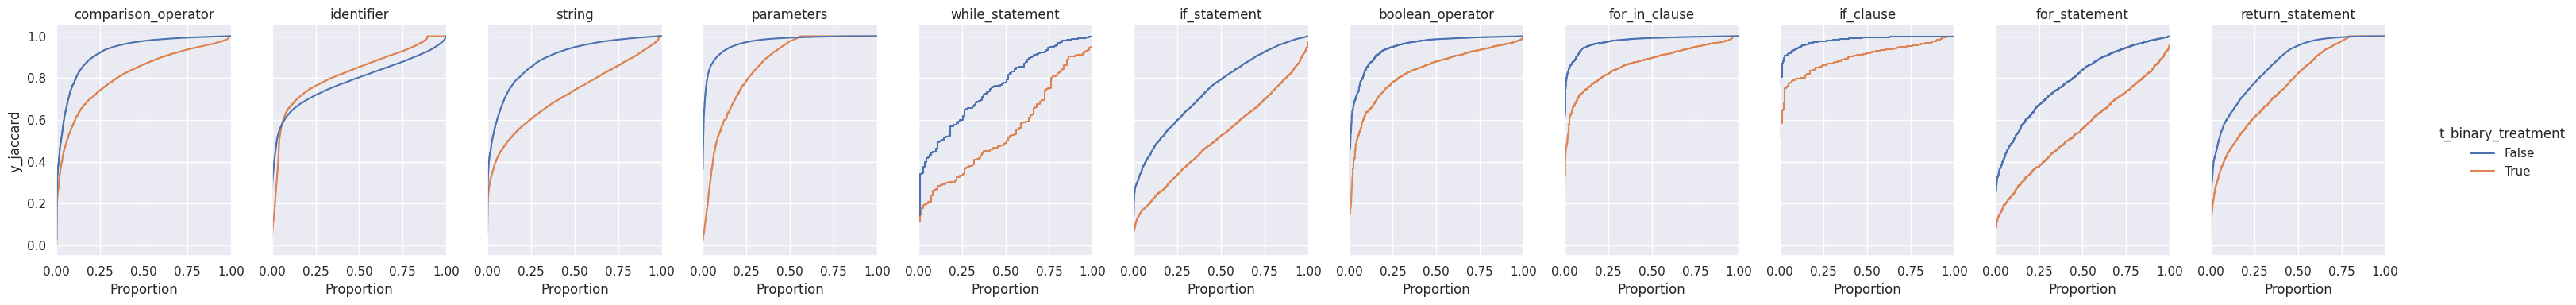

In [59]:
g = sns.displot(
    data=causal_data_df, y="y_jaccard", hue="t_binary_treatment", col="ast_concept",
    kind="ecdf", height=4, aspect=.7,
)
g.set_titles("{col_name}")

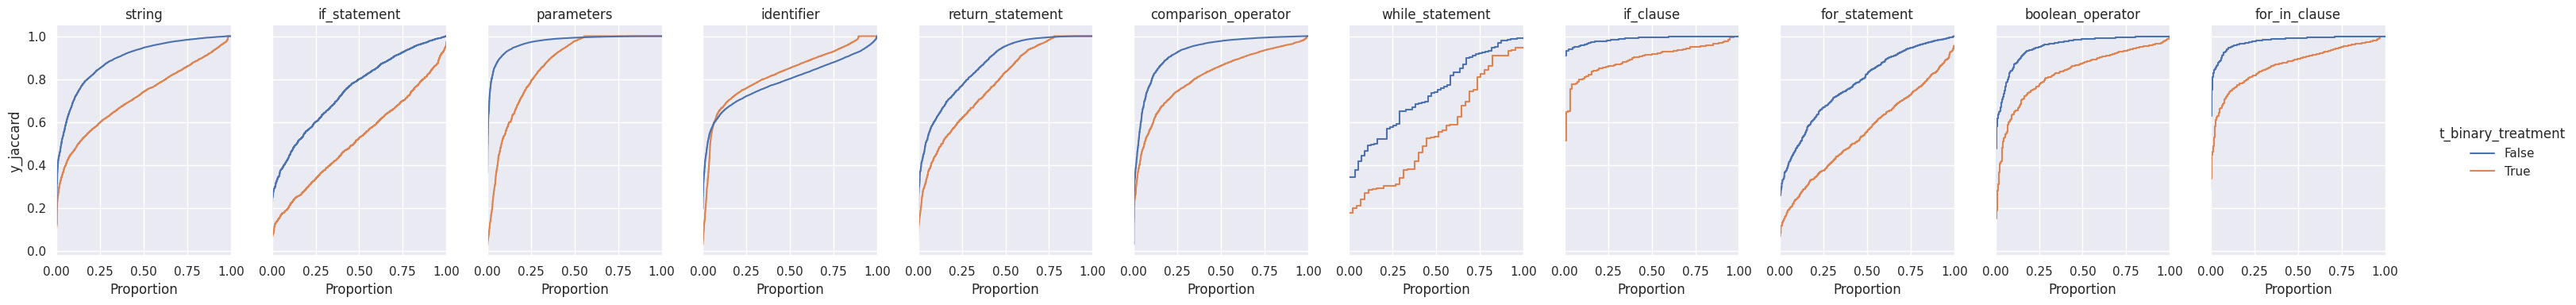

In [22]:

g = sns.displot(
    data=causal_data_sampled_df, y="y_jaccard", hue="t_binary_treatment", col="ast_concept",
    kind="ecdf", height=4, aspect=.7,
)
g.set_titles("{col_name}")

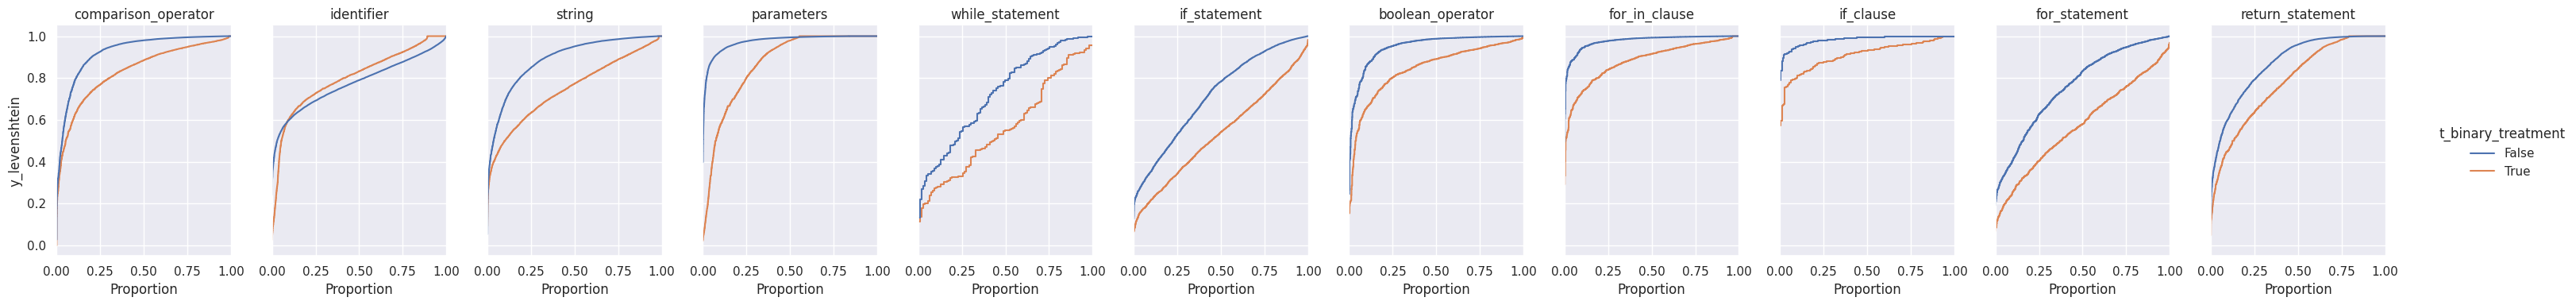

In [60]:
g = sns.displot(
    data=causal_data_df, y="y_levenshtein", hue="t_binary_treatment", col="ast_concept",
    kind="ecdf", height=4, aspect=.7,
)
g.set_titles("{col_name}")

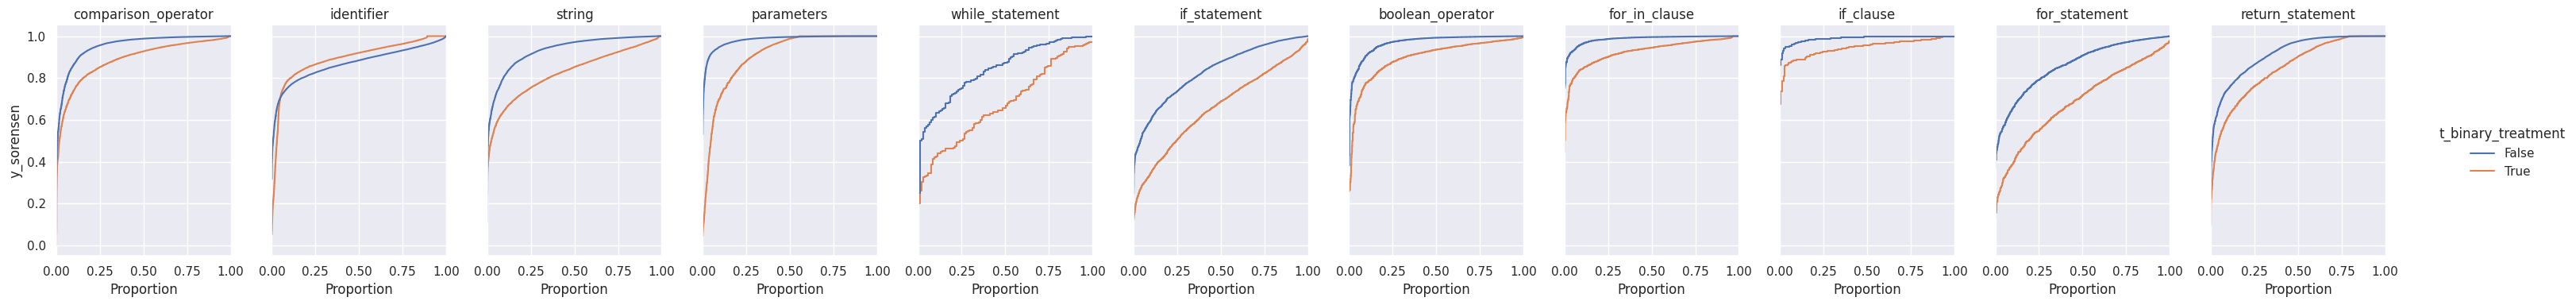

In [61]:
g = sns.displot(
    data=causal_data_df, y="y_sorensen", hue="t_binary_treatment", col="ast_concept",
    kind="ecdf", height=4, aspect=.7,
)
g.set_titles("{col_name}")

# Causal Analysis

## I. Create a causal model from the data and given graph.


In [25]:
concept_set = {'boolean_operator',
 'comparison_operator',
 'for_in_clause',
 'for_statement',
 'identifier',
 'if_clause',
 'if_statement',
 'parameters',
 'return_statement',
 'string',
 'while_statement'}

In [23]:
causal_model_dict = {}

In [18]:
for concept in concept_set:
    causal_model = CausalModel(
        data = causal_data_df[causal_data_df['ast_concept']==concept],
        treatment = ['t_binary_treatment'],
        outcome = ['y_levenshtein'],
        common_causes = ['z_ast_levels','z_n_whitespaces','z_complexity','z_nloc','z_token_counts','z_n_ast_nodes']
    )
    causal_model_dict[concept] = causal_model

In [19]:
causal_model_dict

{'for_in_clause': <dowhy.causal_model.CausalModel at 0x7fd7dcdfbfd0>,
 'if_statement': <dowhy.causal_model.CausalModel at 0x7fd7dc864c70>,
 'return_statement': <dowhy.causal_model.CausalModel at 0x7fd7dc864df0>,
 'identifier': <dowhy.causal_model.CausalModel at 0x7fd7dc864940>,
 'if_clause': <dowhy.causal_model.CausalModel at 0x7fd7dc85f7f0>,
 'boolean_operator': <dowhy.causal_model.CausalModel at 0x7fd7dc85f400>,
 'for_statement': <dowhy.causal_model.CausalModel at 0x7fd7dc85fb50>,
 'parameters': <dowhy.causal_model.CausalModel at 0x7fd7dc85fee0>,
 'while_statement': <dowhy.causal_model.CausalModel at 0x7fd7dc85fe80>,
 'comparison_operator': <dowhy.causal_model.CausalModel at 0x7fd7dc85a970>,
 'string': <dowhy.causal_model.CausalModel at 0x7fd7dc85a550>}

In [26]:
causal_model_dict = {}
for concept in concept_set:
    causal_model = CausalModel(
        data = causal_data_sampled_df[causal_data_sampled_df['ast_concept']==concept],
        treatment = ['t_binary_treatment'],
        outcome = ['y_levenshtein'],
        common_causes = ['z_ast_levels','z_n_whitespaces','z_complexity','z_nloc','z_token_counts','z_n_ast_nodes']
    )
    causal_model_dict[concept] = causal_model

## II. Identify causal effect and return target estimands.


In [27]:
identified_estimand_dict = {}

In [28]:
for c_model in concept_set:
    identified_estimand = causal_model_dict[c_model].identify_effect()
    identified_estimand_dict[c_model] = identified_estimand

# III. Estimate the target estimand using a statistical method.

In [30]:
estimate_dict = {}

In [31]:
for c_model in concept_set:
    estimate = causal_model_dict[c_model].estimate_effect(
        identified_estimand_dict[c_model],
        method_name="backdoor.propensity_score_matching")
    estimate_dict[c_model] = estimate

/usr/local/lib/python3.8/dist-packages/dowhy/causal_estimators/propensity_score_estimator.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.propensity_score_column] = self.propensity_score_model.predict_proba(
/usr/local/lib/python3.8/dist-packages/dowhy/causal_estimators/propensity_score_estimator.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.propensity_score_column] = self.propensity_score_model.predict_proba(
/usr/local/lib/python3.8/dist-packages/dowhy/causal_estimators/p

In [24]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                                   
─────────────────────(E[y_levenshtein|z_complexity,z_n_ast_nodes,z_ast_levels,
d[t_binary_treatment]                                                         

                                       
z_token_counts,z_nloc,z_n_whitespaces])
                                       
Estimand assumption 1, Unconfoundedness: If U→{t_binary_treatment} and U→y_levenshtein then P(y_levenshtein|t_binary_treatment,z_complexity,z_n_ast_nodes,z_ast_levels,z_token_counts,z_nloc,z_n_whitespaces,U) = P(y_levenshtein|t_binary_treatment,z_complexity,z_n_ast_nodes,z_ast_levels,z_token_counts,z_nloc,z_n_whitespaces)

## Realized estimand
b: y_levenshtein~t_binary_treatment+z_complexity+z_n_ast_nodes+z_ast_levels+z_token_counts+z_nloc+z_n_whitespaces
Target units: ate

## Est

In [25]:
for c_model in concept_set:
    print( c_model + ' : ' + str(estimate_dict[c_model].value) )

for_in_clause : -0.052038551143338024
if_statement : -0.13946870411479784
return_statement : -0.11702165308624282
identifier : 0.0043051113901104434
if_clause : -0.058871832848454826
boolean_operator : -0.06818630226794987
for_statement : -0.18968865776267543
parameters : -0.11816462858883073
while_statement : -0.14243244338026323
comparison_operator : -0.18163278788714046
string : -0.10667799430225541


In [32]:
for c_model in concept_set:
    print( c_model + ' : ' + str(estimate_dict[c_model].value) )

comparison_operator : -0.09067556977042915
while_statement : -0.09873069925346972
parameters : -0.10961009103298446
for_in_clause : -0.099890992072105
if_statement : -0.17970647651604837
return_statement : -0.08686845393301805
string : -0.14253438440709212
identifier : 0.02318722526046765
for_statement : -0.18593163893320025
if_clause : -0.07371225387293699
boolean_operator : -0.11103215910177548


# IV. Refute the obtained estimate using multiple robustness checks.

In [29]:
random_common_cause_dict = {}

In [30]:
for c_model in concept_set:
        refute_results = causal_model_dict[c_model].refute_estimate(
                identified_estimand_dict[c_model], 
                estimate_dict[c_model],
                method_name="random_common_cause"
        )
        random_common_cause_dict[c_model] = refute_results

In [31]:
random_common_cause_dict

{'for_in_clause': <dowhy.causal_refuter.CausalRefutation at 0x7fd7d8bd12e0>,
 'if_statement': <dowhy.causal_refuter.CausalRefutation at 0x7fd7d8bc5070>,
 'return_statement': <dowhy.causal_refuter.CausalRefutation at 0x7fd7d93fdf40>,
 'identifier': <dowhy.causal_refuter.CausalRefutation at 0x7fd7d8b5dac0>,
 'if_clause': <dowhy.causal_refuter.CausalRefutation at 0x7fd7d93efa00>,
 'boolean_operator': <dowhy.causal_refuter.CausalRefutation at 0x7fd7dc2c34c0>,
 'for_statement': <dowhy.causal_refuter.CausalRefutation at 0x7fd7d8bcd520>,
 'parameters': <dowhy.causal_refuter.CausalRefutation at 0x7fd7d8bd1e50>,
 'while_statement': <dowhy.causal_refuter.CausalRefutation at 0x7fd7dc1a4850>,
 'comparison_operator': <dowhy.causal_refuter.CausalRefutation at 0x7fd7d8bce0d0>,
 'string': <dowhy.causal_refuter.CausalRefutation at 0x7fd7dc2829a0>}

In [20]:
estimate = causal_model_dict[c_model].estimate_effect(
        identified_estimand_dict[c_model],
        method_name="backdoor.propensity_score_matching")

In [86]:
res_placebo_dict = {}

In [87]:
for c_model in concept_set:
        res_placebo = causal_model_dict[c_model].refute_estimate(
                identified_estimand_dict[c_model], 
                estimate_dict[c_model],
                method_name="placebo_treatment_refuter", 
                placebo_type="permute"
        )
        res_placebo_dict[c_model] = res_placebo

In [ ]:
causal_data_df